In [111]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE

import joblib

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

pd.options.display.max_columns = None

----

# **1. Lectura de datos**

In [2]:
df = pd.read_csv('Processed_UCI_Credit_Card.csv')

In [3]:
df['default.payment.next.month'].sum()/len(df)

0.22125813449023862

In [120]:
df.iloc[0].values

array([ 2.000e+04,  3.913e+03,  3.102e+03,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  2.000e+00,  2.000e+00,
       -1.000e+00, -1.000e+00, -2.000e+00, -2.000e+00,  2.400e+01,
        1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  0.000e+00,  1.000e+00])

----

# **2. Pre-procesamiento**

### *2.1. Particion de datos*

In [5]:
X = df.drop('default.payment.next.month', axis = 1)
y = df['default.payment.next.month']

In [6]:
## Train y test
# Realizamos la base de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
## Train y val
# Realizamos la base de validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=1) # 0.25 x 0.8 = 0.2

### *2.2. Estandarizacion de los datos*

In [7]:
s_scaler = StandardScaler()
X_train_scaled_s = s_scaler.fit_transform(X_train)

In [8]:
mm_scaler = MinMaxScaler()
X_train_scaled_mm = mm_scaler.fit_transform(X_train)

### *2.3. Re-balanceo de datos de entrenamiento*

In [9]:
y_train.sum()/len(y_train)

0.2208131709216308

In [12]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)

#### *2.3.1. Estandarizacion de datos Re-balanceados*

In [13]:
s_scaler_res = StandardScaler()
X_train_res_scaled_s = s_scaler_res.fit_transform(X_res)

In [14]:
mm_scaler_res = MinMaxScaler()
X_train_res_scaled_mm = mm_scaler_res.fit_transform(X_res)

*Guardamos todos los scalers en una lista*

In [15]:
scalers = [s_scaler, mm_scaler, s_scaler_res, mm_scaler_res]

----

# **3. Modelos**

In [16]:
weight = {0:(len(y_train) - y_train.sum()), 1:y_train.sum()}

## **3.1. Regresion Logistica**

#### 3.1.1. RL - Standard Scaler

In [17]:
lr_ss = LogisticRegression(max_iter = 500, class_weight=weight)
lr_ss.fit(X_train_scaled_s, y_train);

#### 3.1.2. RL - MinMax Scaler

In [18]:
lr_mms = LogisticRegression(max_iter = 500, class_weight=weight)
lr_mms.fit(X_train_scaled_mm, y_train);

#### 3.1.3. RL - Rebalanceo - Standard Scaler

In [19]:
lr_res_ss = LogisticRegression(max_iter = 500)
lr_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.1.4. RL - Rebalanceo - MinMax Scaler

In [20]:
lr_res_mms = LogisticRegression(max_iter = 500)
lr_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [21]:
rl_models = [lr_ss, lr_mms, lr_res_ss, lr_res_mms]

## **3.2. Random Forest**

#### 3.2.1. RF - Standard Scaler

In [22]:
rf_ss = RandomForestClassifier(class_weight=weight)
rf_ss.fit(X_train_scaled_s, y_train);

#### 3.2.2. RF - MinMax Scaler

In [23]:
rf_mms = RandomForestClassifier(class_weight=weight)
rf_mms.fit(X_train_scaled_mm, y_train);

#### 3.2.3. RF - Rebalanceo - Standard Scaler

In [24]:
rf_res_ss = RandomForestClassifier()
rf_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.2.4. RF - Rebalanceo - MinMax Scaler

In [25]:
rf_res_mms = RandomForestClassifier()
rf_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [26]:
rf_models = [rf_ss, rf_mms, rf_res_ss, rf_res_mms]

## **3.3. Gradient Boosting**

#### 3.3.1. GB - Standard Scaler

In [27]:
xgb_ss = XGBClassifier(eval_metric = 'auc')
xgb_ss.fit(X_train_scaled_s, y_train);

/home/ruben/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### 3.3.2. GB - MinMax Scaler

In [28]:
xgb_mms = XGBClassifier(eval_metric = 'auc')
xgb_mms.fit(X_train_scaled_mm, y_train);

#### 3.3.3. GB - Rebalanceo - Standard Scaler

In [29]:
xgb_res_ss = XGBClassifier(eval_metric = 'auc')
xgb_res_ss.fit(X_train_res_scaled_s, y_res);

#### 3.3.4. GB - Rebalanceo - MinMax Scaler

In [30]:
xgb_res_mms = XGBClassifier(eval_metric = 'auc')
xgb_res_mms.fit(X_train_res_scaled_mm, y_res);

*Guardamos los modelos en una lista*

In [31]:
xgb_models = [xgb_ss, xgb_mms, xgb_res_ss, xgb_res_mms]

----

# **4. Evaluacion**
Con los datos de validacion

In [32]:
# Escalamos los datos de validacion
scaled_X_vals = []
for scaler in scalers:
    scaled_X_vals.append(scaler.transform(X_val))

In [33]:
y_pred_lr = []
y_pred_rf = []
y_pred_xgb = []

for i, X_val_scaled in enumerate(scaled_X_vals):
    y_pred_lr.append(rl_models[i].predict(X_val_scaled))
    y_pred_rf.append(rf_models[i].predict(X_val_scaled))
    y_pred_xgb.append(xgb_models[i].predict(X_val_scaled))

In [35]:
acc_lr = []
acc_rf = []
acc_xgb = []

pr_lr = []
pr_rf = []
pr_xgb = []

rec_lr = []
rec_rf = []
rec_xgb = []

f1_lr = []
f1_rf = []
f1_xgb = []

for i in range(4):
    
    acc_lr.append(accuracy_score(y_val, y_pred_lr[i]))
    acc_rf.append(accuracy_score(y_val, y_pred_rf[i]))
    acc_xgb.append(accuracy_score(y_val,  y_pred_xgb[i]))
    
    pr_lr.append(precision_score(y_val,  y_pred_lr[i]))
    pr_rf.append(precision_score(y_val,  y_pred_rf[i]))
    pr_xgb.append(precision_score(y_val,  y_pred_xgb[i]))
    
    rec_lr.append(recall_score(y_val, y_pred_lr[i]))
    rec_rf.append(recall_score(y_val, y_pred_rf[i]))
    rec_xgb.append(recall_score(y_val, y_pred_xgb[i]))

    f1_lr.append(f1_score(y_val, y_pred_lr[i]))
    f1_rf.append(f1_score(y_val, y_pred_rf[i]))
    f1_xgb.append(f1_score(y_val, y_pred_xgb[i]))

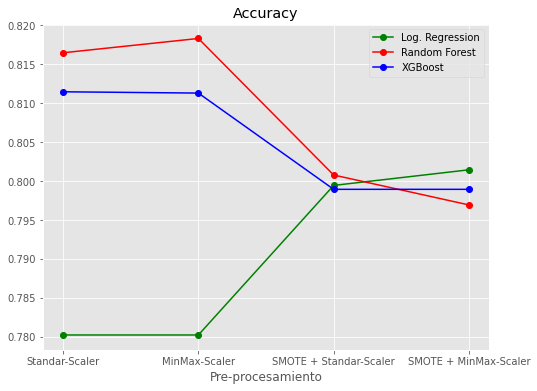

In [52]:
x_labels = ['Standar-Scaler', 'MinMax-Scaler', 'SMOTE + Standar-Scaler', 'SMOTE + MinMax-Scaler']

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(x_labels, acc_lr, '-o', c = 'green')
plt.plot(x_labels, acc_rf, '-o', c = 'red')
plt.plot(x_labels, acc_xgb, '-o', c = 'blue')


ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Accuracy');

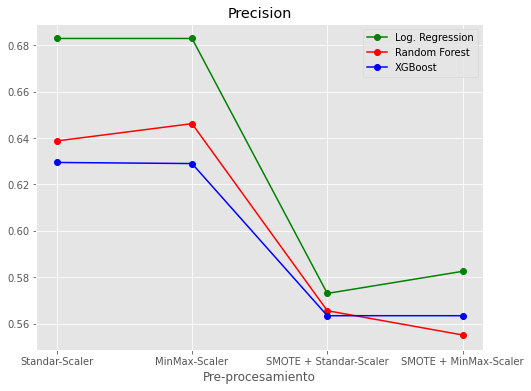

In [54]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, pr_lr, '-o', c = 'green')
plt.plot(x_labels, pr_rf, '-o', c = 'red')
plt.plot(x_labels, pr_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Precision');

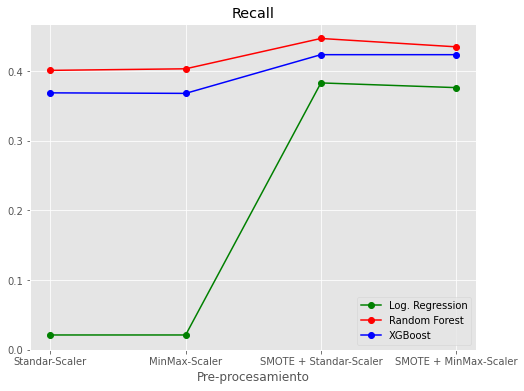

In [55]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, rec_lr, '-o', c = 'green')
plt.plot(x_labels, rec_rf, '-o', c = 'red')
plt.plot(x_labels, rec_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('Recall');

In [212]:
rec_xgb

[0.3686186186186186,
 0.36786786786786785,
 0.42342342342342343,
 0.42342342342342343]

In [213]:
acc_xgb

[0.8114466878024362,
 0.8112798264642083,
 0.7989320874353413,
 0.7989320874353413]

In [214]:
pr_xgb

[0.6294871794871795,
 0.6290115532734275,
 0.5634365634365635,
 0.5634365634365635]

In [215]:
f1_xgb

[0.4649621212121212,
 0.4642349597347229,
 0.48349764252036004,
 0.48349764252036004]

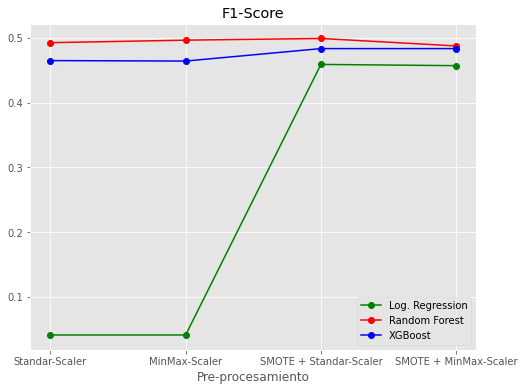

In [56]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x_labels, f1_lr, '-o', c = 'green')
plt.plot(x_labels, f1_rf, '-o', c = 'red')
plt.plot(x_labels, f1_xgb, '-o', c = 'blue')

ax.legend(['Log. Regression', 'Random Forest', 'XGBoost'])
plt.xlabel('Pre-procesamiento')
plt.title('F1-Score');

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))

plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_dt, '-x', c = 'green')
plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_rf, '-o', c = 'red')
plt.plot([str(i) for i in range(1,len(data.columns))], accuracy_xg, '--.', c = 'blue')

ax.legend(['Decision Tree', 'Random Forest', 'XGBoost'])
plt.xlabel('Cantidad de variables')
plt.ylabel('Accuracy');

----

# **5. Sintonizacion de Hiperparametros**
### 5.1. Mejor Regresion Logistica

In [108]:
pipeline_lr = Pipeline([
    ('sc', StandardScaler()),
    ('clf', LogisticRegression(max_iter = 500))
    ])

parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__C': np.logspace(-4, 4, 10),
}

cv_lr = GridSearchCV(pipeline_lr, param_grid=parameters, verbose=0)
cv_lr.fit(X_res, y_res)

GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'clf__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'clf__penalty': ['none', 'l2']})

In [200]:
cv_lr.best_params_

{'clf__C': 1291.5496650148827, 'clf__penalty': 'l2'}

In [103]:
y_pred_final = pd.DataFrame(cv_lr.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.7960954446854663 
 
Precision: 0.5605022831050228 
 
Recall: 0.3697289156626506 
 
F1 Score: 0.44555353901996364 



### 5.2. Mejor Random Forest

In [88]:
pipeline_rf = Pipeline([
    ('sc', MinMaxScaler()),
    ('clf', RandomForestClassifier())
    ])

parameters = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__min_samples_split': [2, 10, 100],
    'clf__min_samples_leaf': [1, 5, 10]
}

cv_rf = GridSearchCV(pipeline_rf, param_grid=parameters, verbose=0)
cv_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__min_samples_leaf': [1, 5, 10],
                         'clf__min_samples_split': [2, 10, 100]})

In [201]:
cv.best_params_

{'clf__criterion': 'entropy',
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 100}

In [92]:
y_pred_final = pd.DataFrame(cv_rf.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.8184548640080094 
 
Precision: 0.6621621621621622 
 
Recall: 0.3689759036144578 
 
F1 Score: 0.47388781431334615 



### 5.3. Mejor XGBoost

In [107]:
pipeline_xgb = Pipeline([
    ('sc', StandardScaler()),
    ('clf', XGBClassifier(eval_metric = 'auc'))
    ])

parameters = {
    'clf__min_child_weight': [1, 5, 10],
    'clf__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__max_depth': [3, 4, 5]
}

cv_xgb = GridSearchCV(pipeline_xgb, param_grid=parameters, verbose=0)
cv_xgb.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('sc', MinMaxScaler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                     

In [202]:
cv_xgb.best_params_

{'clf__gamma': 5, 'clf__max_depth': 3, 'clf__min_child_weight': 1}

In [109]:
y_pred_final = pd.DataFrame(cv_xgb.predict(X_test))
print(
'''
Accuracy: {} \n 
Precision: {} \n 
Recall: {} \n 
F1 Score: {} \n'''.format(accuracy_score(y_test, y_pred_final),
                                  precision_score(y_test, y_pred_final),
                                  recall_score(y_test, y_pred_final),
                                  f1_score(y_test, y_pred_final))
)


Accuracy: 0.8179542799933256 
 
Precision: 0.6612244897959184 
 
Recall: 0.36596385542168675 
 
F1 Score: 0.4711585070285991 



In [219]:
accs = []
prec = []
recs = []
f1s = []

y_pred_final = pd.DataFrame(cv_lr.predict(X_test))
accs.append(accuracy_score(y_test, y_pred_final))
prec.append(precision_score(y_test, y_pred_final))
recs.append(recall_score(y_test, y_pred_final))
f1s.append(f1_score(y_test, y_pred_final))

In [220]:
y_pred_final = pd.DataFrame(cv_rf.predict(X_test))
accs.append(accuracy_score(y_test, y_pred_final))
prec.append(precision_score(y_test, y_pred_final))
recs.append(recall_score(y_test, y_pred_final))
f1s.append(f1_score(y_test, y_pred_final))

In [221]:
y_pred_final = pd.DataFrame(cv_xgb.predict(X_test))
accs.append(accuracy_score(y_test, y_pred_final))
prec.append(precision_score(y_test, y_pred_final))
recs.append(recall_score(y_test, y_pred_final))
f1s.append(f1_score(y_test, y_pred_final))

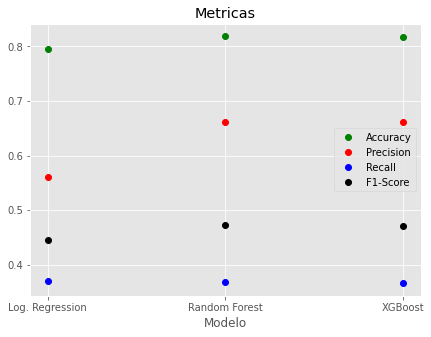

In [229]:
x_labels = ['Log. Regression', 'Random Forest', 'XGBoost']

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(x_labels, accs, 'o', c = 'green')
plt.plot(x_labels, prec, 'o', c = 'red')
plt.plot(x_labels, recs, 'o', c = 'blue')
plt.plot(x_labels, f1s, 'o', c = 'black')


ax.legend(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
plt.xlabel('Modelo')
plt.title('Metricas');
plt.savefig('imgs/modelos.png')

array([4.90465000e-02, 4.25538326e-02, 3.60321875e-02, 3.56372975e-02,
       3.27153724e-02, 3.10099524e-02, 3.02200496e-02, 5.08097067e-02,
       4.29540593e-02, 3.48296588e-02, 3.26354197e-02, 2.96705604e-02,
       3.11234461e-02, 2.09264365e-01, 9.82156015e-02, 5.73252459e-02,
       3.89573874e-02, 3.71553673e-02, 3.41238073e-02, 2.64491251e-02,
       3.49413554e-03, 2.25480067e-03, 1.57224692e-04, 3.39885893e-03,
       3.21669535e-03, 2.98371785e-03, 1.39798113e-03, 2.36764357e-03])

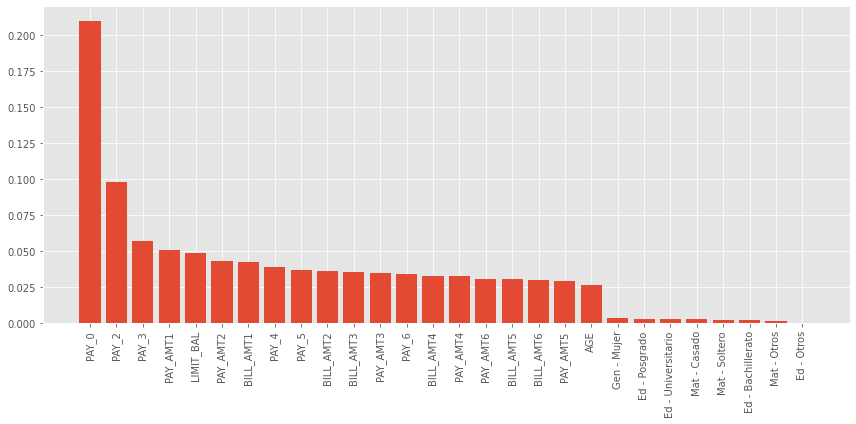

In [256]:

# Extraemos la importancia de las caracteristicas
importancia_rf = pd.DataFrame(list(zip(X_train.columns,cv.best_estimator_['clf'].feature_importances_)),columns=['atributo','importancia'])
importancia_rf = importancia_rf.sort_values(by=['importancia'],ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
plt.bar(importancia_rf['atributo'], importancia_rf['importancia'])
plt.xticks(rotation=90);
#importancia_rf
plt.tight_layout();
plt.savefig('imgs/fimportance.png')

Gana Random Forest!

----

# **6. Guardar el modelo**

In [113]:
model_filepath = 'modelos/model.pkl'
joblib.dump(cv_rf, model_filepath)

['modelos/model.pkl']

# **Anexo: Distribuciones entre los conjuntos de entrenamiento**

In [121]:
X_train

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,AGE,Gen - Mujer,Ed - Bachillerato,Ed - Otros,Ed - Posgrado,Ed - Universitario,Mat - Casado,Mat - Otros,Mat - Soltero
24726,70000.0,60412.0,67474.0,68750.0,59186.0,48178.0,46197.0,8137.0,3100.0,7172.0,10000.0,1662.0,3000.0,0,0,0,0,0,0,39,0,0,0,1,0,1,0,0
20831,50000.0,34617.0,34390.0,810.0,19009.0,18035.0,18364.0,1000.0,810.0,51000.0,0.0,1000.0,1000.0,0,0,-1,-1,2,0,39,0,1,0,0,0,0,0,1
3349,30000.0,23171.0,22523.0,21863.0,23296.0,22783.0,24310.0,0.0,0.0,1800.0,0.0,1910.0,780.0,1,3,2,2,2,2,44,0,0,0,0,1,1,0,0
21741,50000.0,48393.0,49405.0,50934.0,7728.0,8390.0,48679.0,1814.0,2343.0,1137.0,799.0,41933.0,1943.0,0,0,0,0,0,0,24,1,0,0,0,1,0,0,1
5648,30000.0,0.0,0.0,0.0,239.0,89.0,589.0,0.0,0.0,239.0,0.0,500.0,0.0,1,-2,-2,-1,2,2,38,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9220,280000.0,415.0,415.0,415.0,565.0,830.0,415.0,415.0,415.0,565.0,830.0,0.0,415.0,-1,-1,-1,-1,-1,2,40,1,0,0,0,1,1,0,0
1862,500000.0,407331.0,403816.0,386053.0,389008.0,392650.0,391336.0,15043.0,14000.0,14003.0,14011.0,15003.0,14009.0,0,0,0,0,0,0,46,0,0,0,1,0,1,0,0
9952,280000.0,0.0,0.0,0.0,0.0,0.0,35833.0,0.0,0.0,0.0,0.0,35833.0,1500.0,1,-2,-2,-2,-2,-1,33,1,0,0,0,1,0,0,1
26109,30000.0,26844.0,26414.0,27189.0,28235.0,28669.0,29355.0,300.0,1500.0,1800.0,1200.0,1300.0,1200.0,2,2,2,0,0,0,29,1,0,0,0,1,1,0,0


· Proporción 

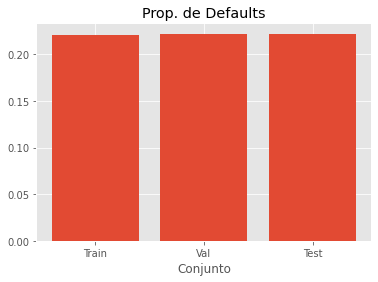

In [146]:
props = [
        sum(y_train)/len(y_train),
        sum(y_val)/len(y_val),
        sum(y_test)/len(y_test)
        ]
props_x = ['Train', 'Val', 'Test']
plt.bar(props_x, props)
plt.xlabel('Conjunto')
plt.title('Prop. de Defaults');
plt.savefig('imgs/props_y.png')

. Dist. Edad
· Dist Monto
· Dist Genero
· Dist Educacion
· Estado civil

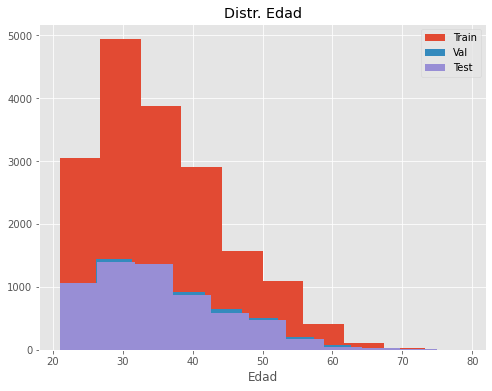

In [151]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

plt.hist(X_train.AGE)
plt.hist(X_val.AGE)
plt.hist(X_test.AGE)
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Edad')
plt.title('Distr. Edad');
plt.savefig('imgs/edad.png')

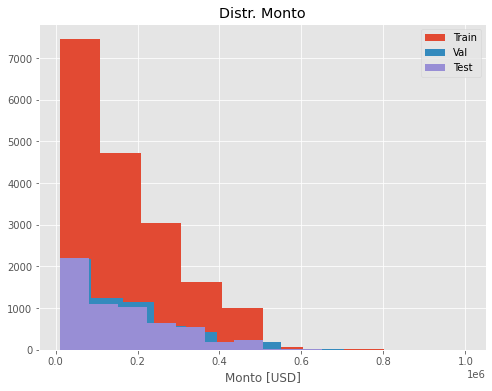

In [154]:
props_x = ['Train', 'Val', 'Test']

fig, ax = plt.subplots(figsize=(8,6))

plt.hist(X_train.LIMIT_BAL)
plt.hist(X_val.LIMIT_BAL)
plt.hist(X_test.LIMIT_BAL)
ax.legend( ['Train', 'Val', 'Test'])

plt.xlabel('Monto [USD]')
plt.title('Distr. Monto');
plt.savefig('imgs/monto.png')

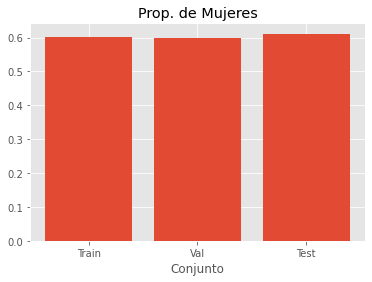

In [156]:
props = [
        sum(X_train['Gen - Mujer'])/len(X_train),
        sum(X_val['Gen - Mujer'])/len(X_val),
        sum(X_test['Gen - Mujer'])/len(X_test)
        ]
props_x = ['Train', 'Val', 'Test']
plt.bar(props_x, props)
plt.xlabel('Conjunto')
plt.title('Prop. de Mujeres');
plt.savefig('imgs/genero.png')

· Estado civil

In [157]:
X_train

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,AGE,Gen - Mujer,Ed - Bachillerato,Ed - Otros,Ed - Posgrado,Ed - Universitario,Mat - Casado,Mat - Otros,Mat - Soltero
24726,70000.0,60412.0,67474.0,68750.0,59186.0,48178.0,46197.0,8137.0,3100.0,7172.0,10000.0,1662.0,3000.0,0,0,0,0,0,0,39,0,0,0,1,0,1,0,0
20831,50000.0,34617.0,34390.0,810.0,19009.0,18035.0,18364.0,1000.0,810.0,51000.0,0.0,1000.0,1000.0,0,0,-1,-1,2,0,39,0,1,0,0,0,0,0,1
3349,30000.0,23171.0,22523.0,21863.0,23296.0,22783.0,24310.0,0.0,0.0,1800.0,0.0,1910.0,780.0,1,3,2,2,2,2,44,0,0,0,0,1,1,0,0
21741,50000.0,48393.0,49405.0,50934.0,7728.0,8390.0,48679.0,1814.0,2343.0,1137.0,799.0,41933.0,1943.0,0,0,0,0,0,0,24,1,0,0,0,1,0,0,1
5648,30000.0,0.0,0.0,0.0,239.0,89.0,589.0,0.0,0.0,239.0,0.0,500.0,0.0,1,-2,-2,-1,2,2,38,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9220,280000.0,415.0,415.0,415.0,565.0,830.0,415.0,415.0,415.0,565.0,830.0,0.0,415.0,-1,-1,-1,-1,-1,2,40,1,0,0,0,1,1,0,0
1862,500000.0,407331.0,403816.0,386053.0,389008.0,392650.0,391336.0,15043.0,14000.0,14003.0,14011.0,15003.0,14009.0,0,0,0,0,0,0,46,0,0,0,1,0,1,0,0
9952,280000.0,0.0,0.0,0.0,0.0,0.0,35833.0,0.0,0.0,0.0,0.0,35833.0,1500.0,1,-2,-2,-2,-2,-1,33,1,0,0,0,1,0,0,1
26109,30000.0,26844.0,26414.0,27189.0,28235.0,28669.0,29355.0,300.0,1500.0,1800.0,1200.0,1300.0,1200.0,2,2,2,0,0,0,29,1,0,0,0,1,1,0,0


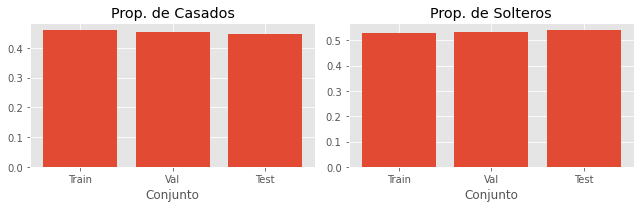

In [198]:
props_casados = [
                sum(X_train['Mat - Casado'])/len(X_train),
                sum(X_val['Mat - Casado'])/len(X_val),
                sum(X_test['Mat - Casado'])/len(X_test)
                ]
props_solteros = [
                sum(X_train['Mat - Soltero'])/len(X_train),
                sum(X_val['Mat - Soltero'])/len(X_val),
                sum(X_test['Mat - Soltero'])/len(X_test)
                ]
props_x = ['Train', 'Val', 'Test']


x = np.arange(len(props_x))  # the label locations
width = 0.35  # the width of the bars



fig, ax = plt.subplots(1,2, figsize=(9,3))
rects1 = ax[0].bar(props_x, props_casados, label='Casados')
rects2 = ax[1].bar(props_x, props_solteros, label='Solteros')


ax[0].set_title('Prop. de Casados')
ax[1].set_title('Prop. de Solteros')

ax[0].set_xlabel('Conjunto')
ax[1].set_xlabel('Conjunto')
plt.tight_layout();
plt.savefig('imgs/estado_civil.png')

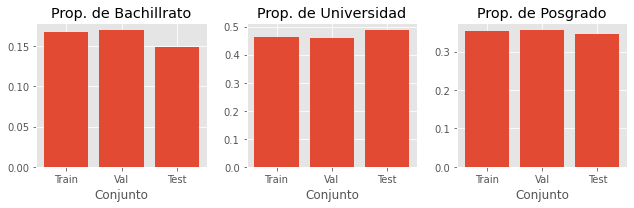

In [199]:
props_bach = [
                sum(X_train['Ed - Bachillerato'])/len(X_train),
                sum(X_val['Ed - Bachillerato'])/len(X_val),
                sum(X_test['Ed - Bachillerato'])/len(X_test)
                ]
props_uni = [
                sum(X_train['Ed - Universitario'])/len(X_train),
                sum(X_val['Ed - Universitario'])/len(X_val),
                sum(X_test['Ed - Universitario'])/len(X_test)
                ]

props_pos = [
                sum(X_train['Ed - Posgrado'])/len(X_train),
                sum(X_val['Ed - Posgrado'])/len(X_val),
                sum(X_test['Ed - Posgrado'])/len(X_test)
                ]

props_x = ['Train', 'Val', 'Test']


fig, ax = plt.subplots(1,3, figsize=(9,3))
rects1 = ax[0].bar(props_x, props_bach, label='Bachillrato')
rects2 = ax[1].bar(props_x, props_uni, label='Universidad')
rects3 = ax[2].bar(props_x, props_pos, label='Posgrado')

ax[0].set_title('Prop. de Bachillrato')
ax[1].set_title('Prop. de Universidad')
ax[2].set_title('Prop. de Posgrado')


ax[0].set_xlabel('Conjunto')
ax[1].set_xlabel('Conjunto')
ax[2].set_xlabel('Conjunto');
plt.tight_layout()
plt.savefig('imgs/edu.png')